In [1]:
import sys
sys.path.append("../functions")
from import_auxiliary import import_data, get_R0, array_persev_computation

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.tri as tri

path_CM_red = "../data/compliant_matrix.json"
path_CM_yellow = "../data/non_compliant_matrix.json"
path_Nij = "../data/Nij.json"

# global variables
n_comp = 14                                                                                 # number of compartments
age_groups = ['0-4', '5-17', '18-29', '30-39', '40-49', '50-59', '60+']                     # list of strings with age groups 
age_groups_bins = [0, 5, 18, 30, 40, 50, 60, np.inf]                                        # list of int with age groups extremes 
n_age = len(age_groups)                                                                     # number of age groups
n_sev = 5                                                                                   # number of perceived severity groups

In [2]:
# import data
Italy_dict = import_data(path_CM_red, path_CM_yellow, path_Nij)

# parameters

beta = 0.08                                                         # attack rate
mu = 1 / 5                                                          # inverse of infectious period
omega = 1 / 1.8 #2.3                                                # inverse of presymptomatic period
chi = 0.55                                                          # reduced infectiousness of presymptomatics and asymptomatics
icu0 = 2500 / np.sum(Italy_dict["Nij"])                             # initial fraction of ICU
ICU_max = 7200                                                      # max number of ICU
ICU_0 = 2500 / ICU_max                                              # initial occupancy of ICU
f = [0.397, 0.573, 0.476, 0.407, 0.329, 0.265, 0.152]               # Fraction of asymptomatics for each age group                     

function_types = ['lin', 'centerlin', 'startendlin', 'startlin', 'endlin']

In [3]:
# behavioral parameters
alpha = 10                                                          # slope of C->NC transition
gamma = 5                                                           # slope of NC->C transition
a0s = np.linspace(0.01, 1, num=30)                                  # array of midpoints of C->NC transition
b0 = 0.75                                                           # midpoint of NC->C transition
maxsigmaa0 = 0.3                                                    # maxium value of variance
sigma_a0s = np.linspace(0, maxsigmaa0, num=30)                      # array of variance of midpoint of C->NC transition

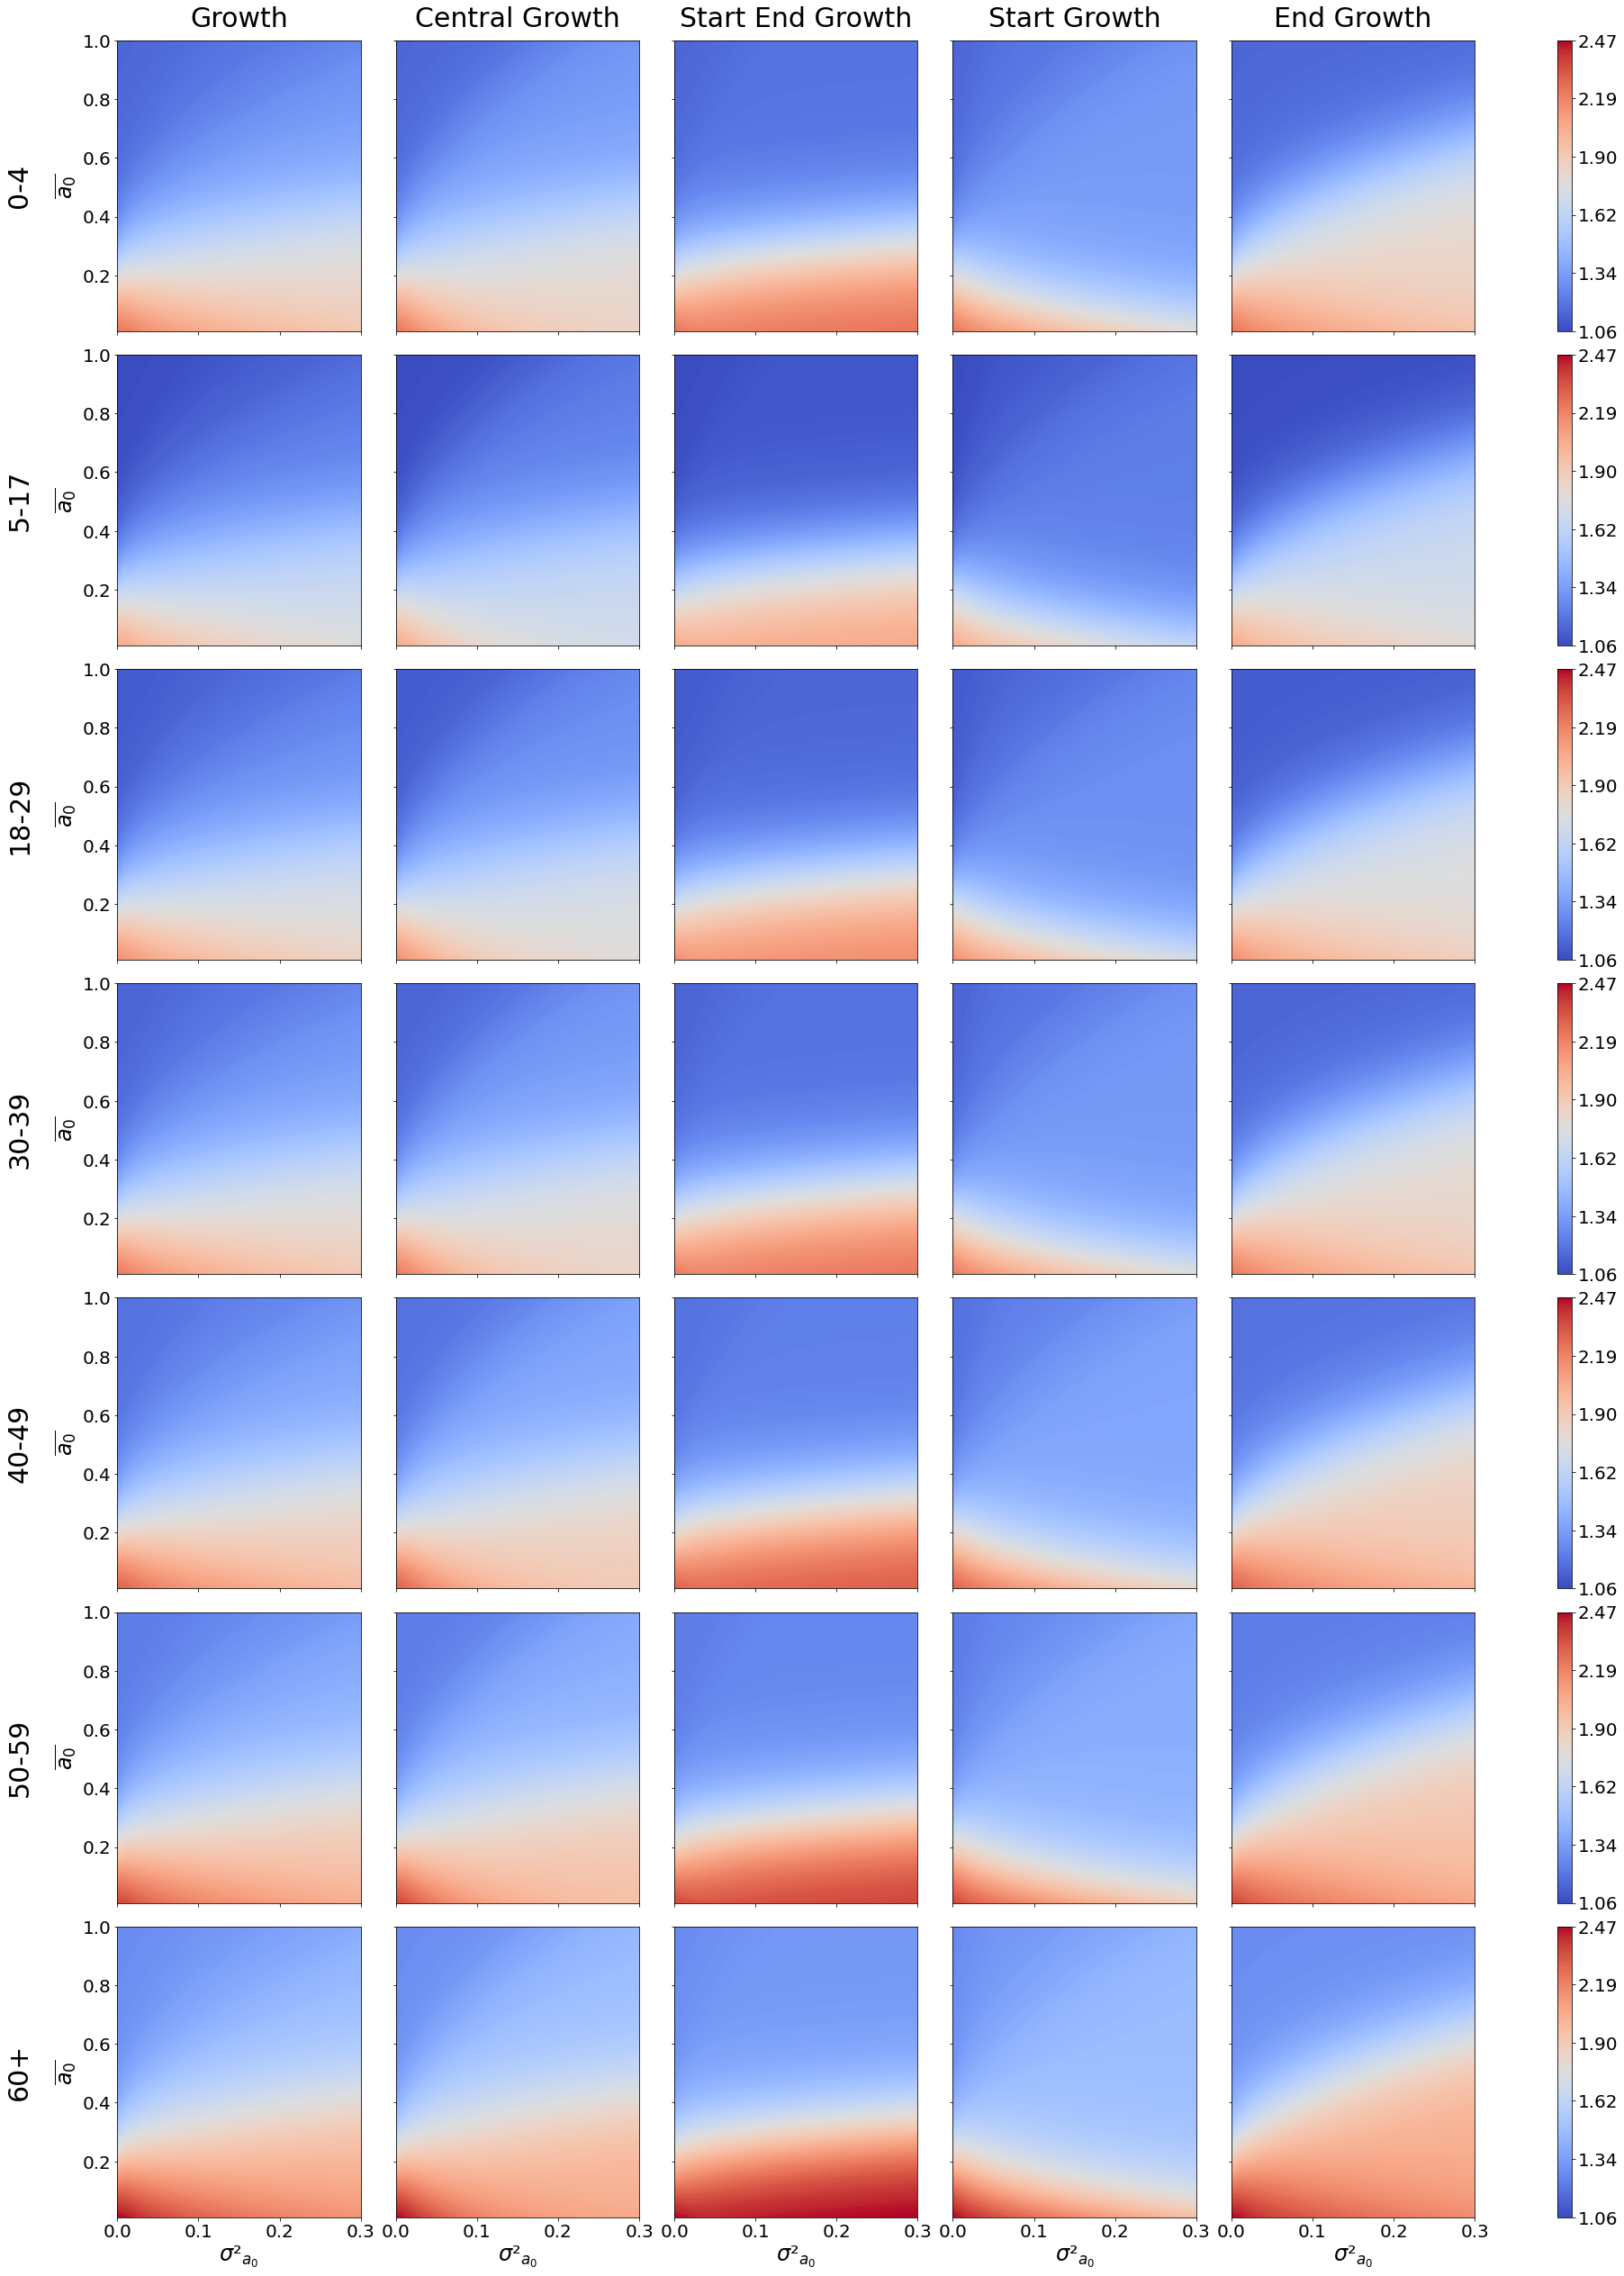

In [4]:
# Plot R0 for every age group

a0_plot = []
sigma_a0_plot = []
R0_dict = {}

# generate data
for i, age in zip(range(n_age), age_groups):
    for j, fun_type in zip(range(len(function_types)), function_types):
        R0_plot = []
        for a0 in a0s:
            for sigma_a0 in sigma_a0s:
                if i == 0 and j == 0:
                    a0_plot.append(a0)
                    sigma_a0_plot.append(sigma_a0)
                a0_vec = array_persev_computation(Italy_dict['Nij'], a0, sigma_a0, fun_type, grow = True)
                R0_plot.append(get_R0(i, beta, omega, mu, chi, f, Italy_dict['CM_red'], Italy_dict['CM_yellow'], Italy_dict['Nij'], [alpha]*5, [gamma]*5, a0_vec, [b0]*5, ICU_0))
        
        R0_dict[i,j] = R0_plot
        if i == 0 and j == 0:
            min_value = min(R0_plot)
            max_value = max(R0_plot)
        else:
            if min_value > min(R0_plot):
                min_value = min(R0_plot)
            if max_value < max(R0_plot):
                max_value = max(R0_plot)

# plot
fig, axes = plt.subplots(7, 5, figsize=(25,35), sharey = 'row', sharex = 'col', constrained_layout=True)

function_types_labels = ['Growth', 'Central Growth', 'Start End Growth', 'Start Growth', 'End Growth']
                
for i, age in zip(range(n_age),age_groups):
    for j, fun_type in zip(range(len(function_types)), function_types):
        triang = tri.Triangulation(sigma_a0_plot, a0_plot)
        cntrf = axes[i,j].tricontourf(triang, R0_dict[i,j], levels = 200, cmap = cm.coolwarm, norm = colors.Normalize(min_value, max_value))

        if i == 0:
            axes[i, j].set_title(function_types_labels[j], fontsize = 30, pad = 15)
        if j == 0:
            axes[i,j].set_ylabel(r"$\overline{a_0}$", fontsize = 24)
            axes[i,j].yaxis.set_tick_params(labelsize=20)
        if i == len(axes[:,0])-1:
            axes[i,j].set_xlabel(r"$\sigma²_{a_0}$", fontsize = 24)
            axes[i,j].xaxis.set_tick_params(labelsize=20)
            axes[i,j].xaxis.set_ticks([0.0, 0.1, 0.2, 0.3])

    cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(min_value, max_value), cmap=cm.coolwarm), ax=axes[i,:])
    cbar.ax.tick_params(labelsize=20)
    cbar.set_ticks(np.linspace(min_value, max_value, 6))
    cbar.set_ticklabels([f'{tick:.2f}' for tick in np.linspace(min_value, max_value, 6)])

pad = 20 # in points
rows = age_groups 
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad-pad,0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                ha='right', va='center', rotation = 90, fontsize = 30)

plt.tight_layout
plt.savefig('../output/main/R0/R0_allages.png', bbox_inches='tight')
plt.show()

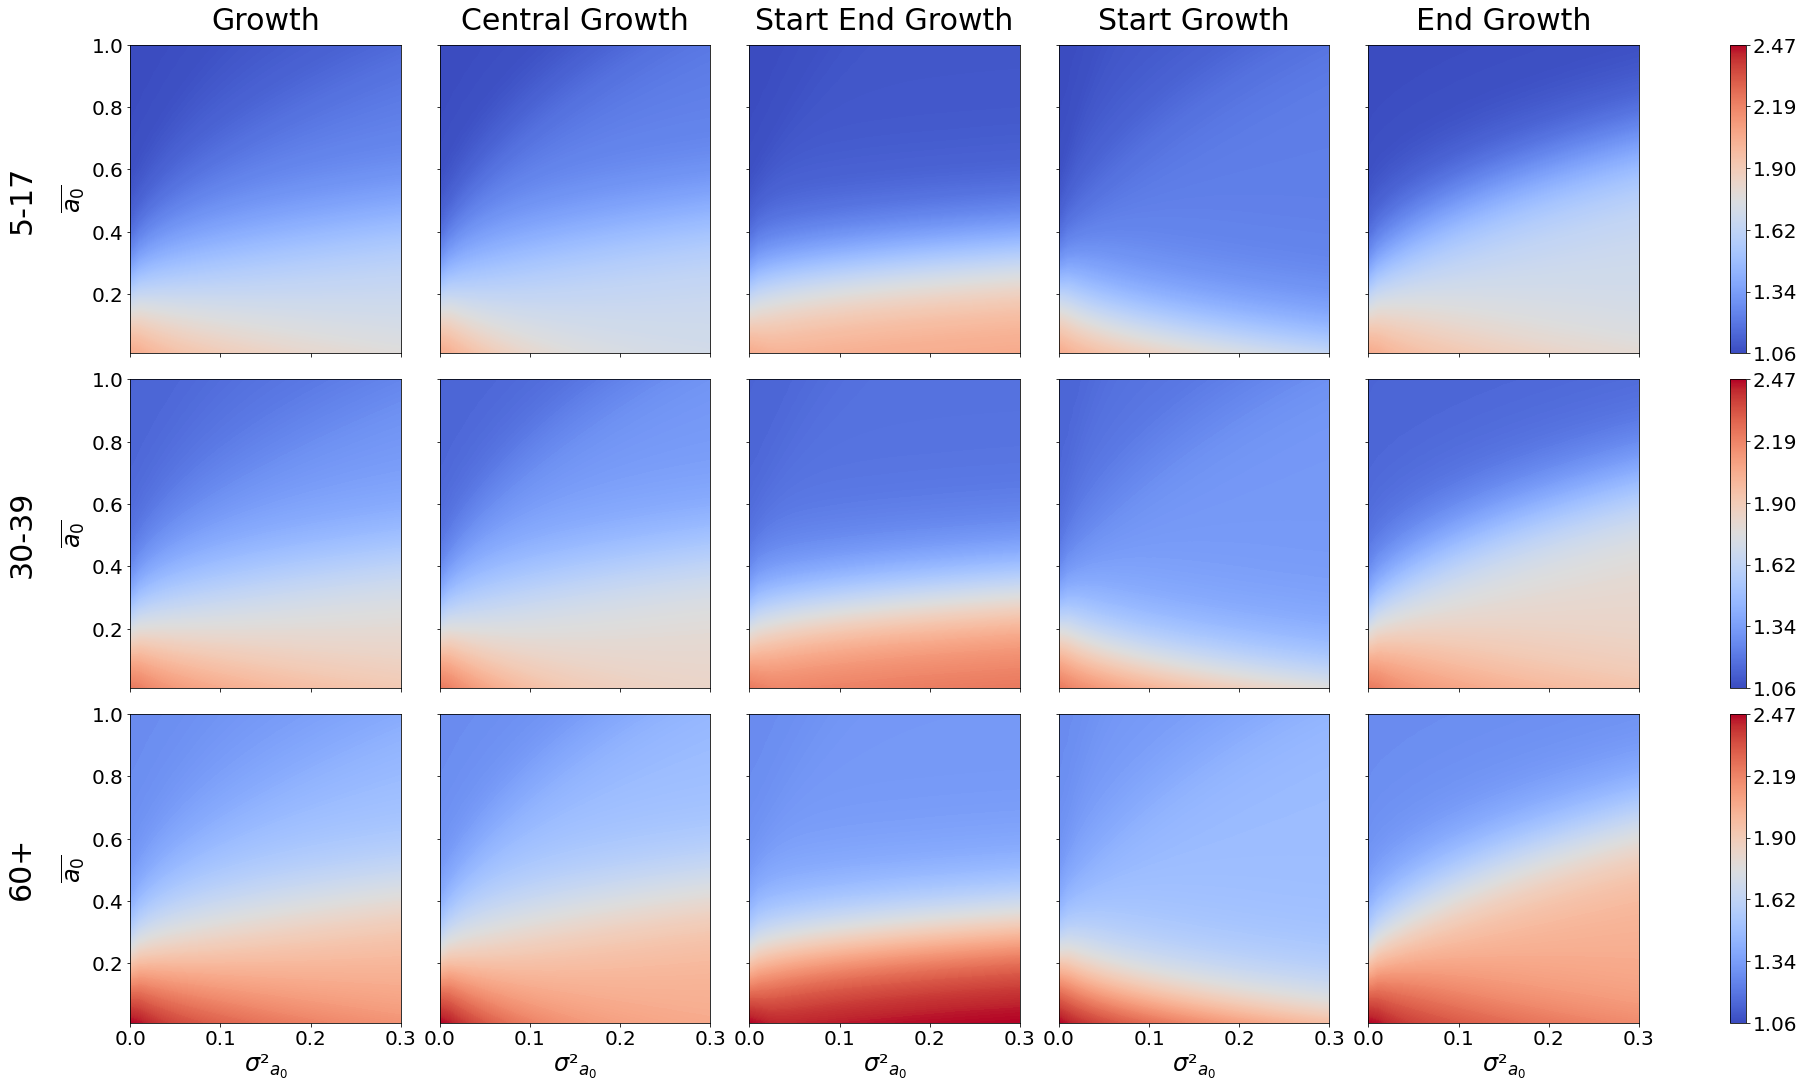

In [5]:
# Plot R0 for three age group

age_index = [1,3,6]

a0_plot = []
sigma_a0_plot = []
R0_dict = {}

# generate data
for i in range(len(age_index)):
    for j, fun_type in zip(range(len(function_types)), function_types):
        R0_plot = []
        for a0 in a0s:
            for sigma_a0 in sigma_a0s:
                if i == 0 and j == 0:
                    a0_plot.append(a0)
                    sigma_a0_plot.append(sigma_a0)
                a0_vec = array_persev_computation(Italy_dict['Nij'], a0, sigma_a0, fun_type, grow = True)
                R0_plot.append(get_R0(age_index[i], beta, omega, mu, chi, f, Italy_dict['CM_red'], Italy_dict['CM_yellow'], Italy_dict['Nij'], [alpha]*5, [gamma]*5, a0_vec, [b0]*5, ICU_0))
        
        R0_dict[i,j] = R0_plot
        if i == 0 and j == 0:
            min_value = min(R0_plot)
            max_value = max(R0_plot)
        else:
            if min_value > min(R0_plot):
                min_value = min(R0_plot)
            if max_value < max(R0_plot):
                max_value = max(R0_plot)

# plot
fig, axes = plt.subplots(len(age_index), 5, figsize=(25,5*len(age_index)), sharey = 'row', sharex = 'col', constrained_layout=True)

function_types_labels = ['Growth', 'Central Growth', 'Start End Growth', 'Start Growth', 'End Growth']
                
for i in range(len(age_index)):
    for j, fun_type in zip(range(len(function_types)), function_types):
        triang = tri.Triangulation(sigma_a0_plot, a0_plot)
        cntrf = axes[i,j].tricontourf(triang, R0_dict[i,j], levels = 200, cmap = cm.coolwarm, norm = colors.Normalize(min_value, max_value))

        if i == 0:
            axes[i, j].set_title(function_types_labels[j], fontsize = 30, pad = 15)
        if j == 0:
            axes[i,j].set_ylabel(r"$\overline{a_0}$", fontsize = 24)
            axes[i,j].yaxis.set_tick_params(labelsize=20)
        if i == len(axes[:,0])-1:
            axes[i,j].set_xlabel(r"$\sigma²_{a_0}$", fontsize = 24)
            axes[i,j].xaxis.set_tick_params(labelsize=20)
            axes[i,j].xaxis.set_ticks([0.0, 0.1, 0.2, 0.3])

    cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(min_value, max_value), cmap=cm.coolwarm), ax=axes[i,:])
    cbar.ax.tick_params(labelsize=20)
    cbar.set_ticks(np.linspace(min_value, max_value, 6))
    cbar.set_ticklabels([f'{tick:.2f}' for tick in np.linspace(min_value, max_value, 6)])

pad = 20 # in points
rows = [age_groups[k] for k in age_index] 
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad-pad,0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                ha='right', va='center', rotation = 90, fontsize = 30)

plt.tight_layout
plt.savefig('../output/main/R0/R0_3ages.png', bbox_inches='tight')
plt.show()

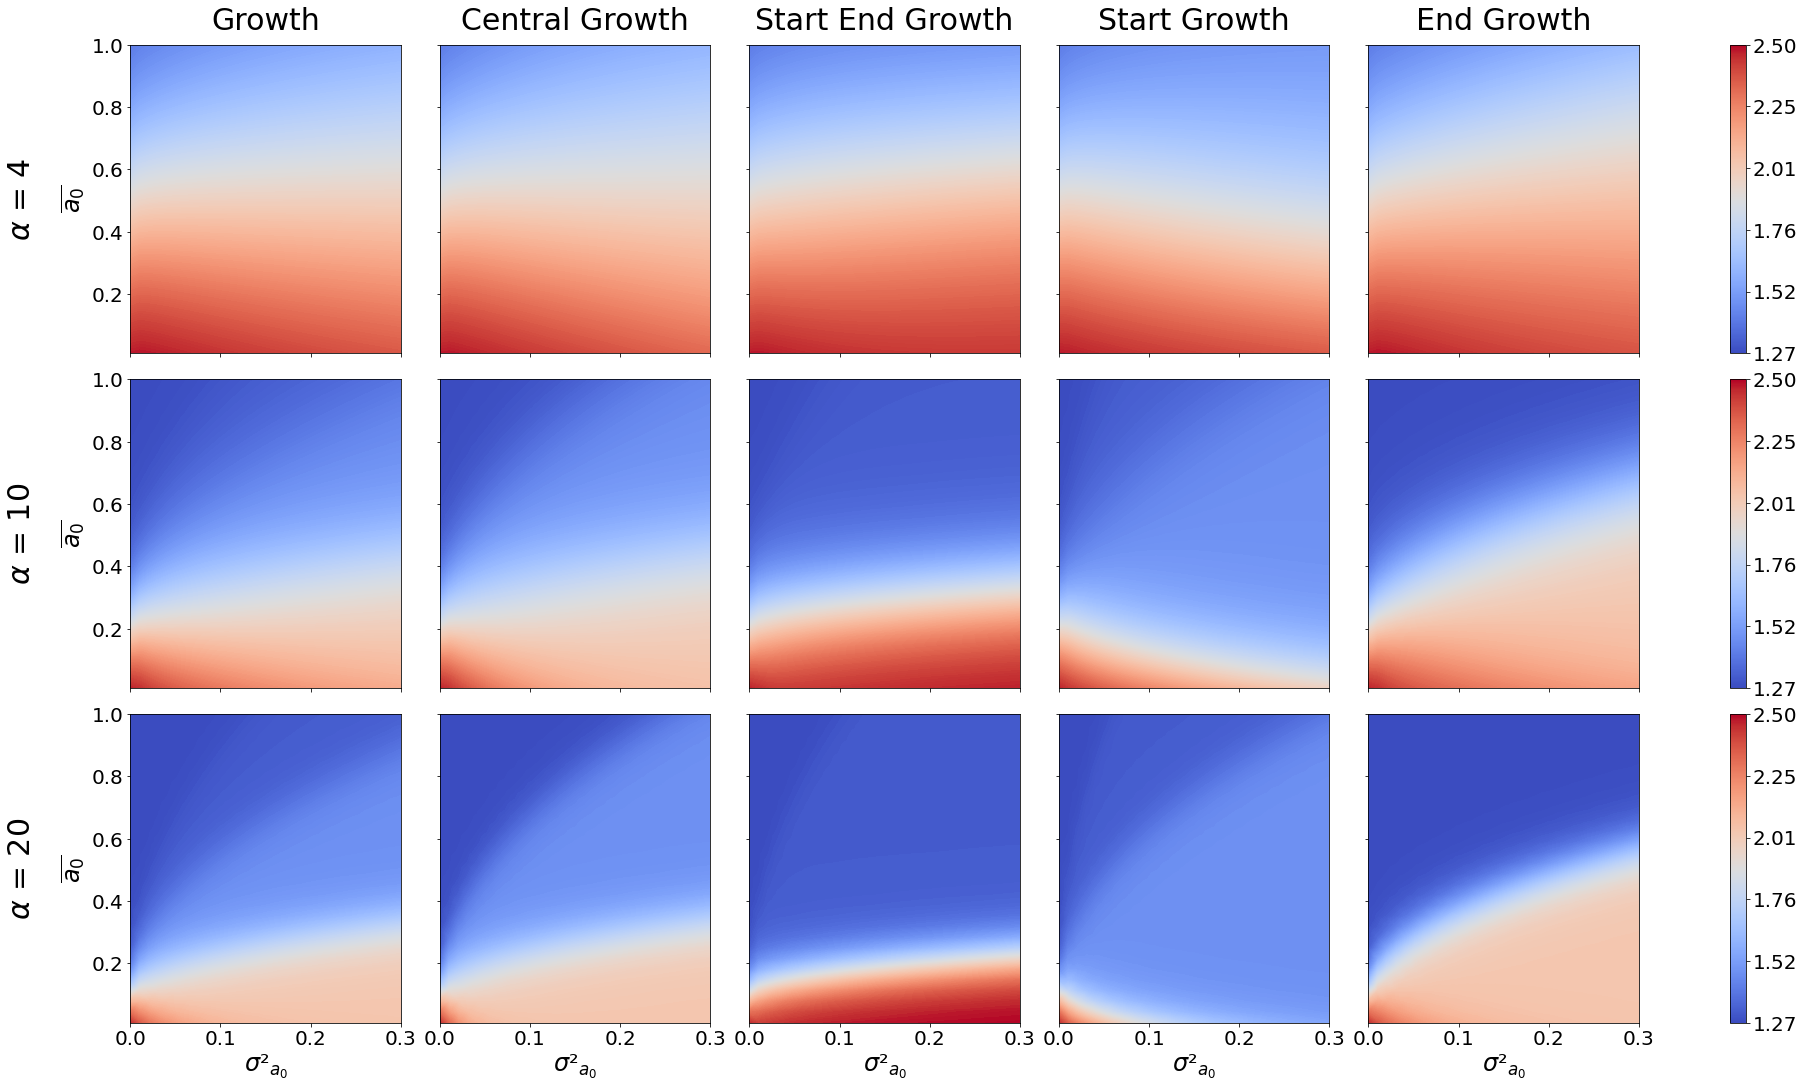

In [6]:
# Plot R0 for different slopes of C->NC transition

alphas = [4, 10, 20]

a0_plot = []
sigma_a0_plot = []
R0_dict = {}

# generate data
for i, alpha in zip(range(len(alphas)),alphas):
    for j, fun_type in zip(range(len(function_types)), function_types):
        R0_plot = []
        for a0 in a0s:
            for sigma_a0 in sigma_a0s:
                if i == 0 and j == 0:
                    a0_plot.append(a0)
                    sigma_a0_plot.append(sigma_a0)
                a0_vec = array_persev_computation(Italy_dict['Nij'], a0, sigma_a0, fun_type, grow = True)
                R0_plot.append(get_R0(-1, beta, omega, mu, chi, f, Italy_dict['CM_red'], Italy_dict['CM_yellow'], Italy_dict['Nij'], [alpha]*5, [gamma]*5, a0_vec, [b0]*5, ICU_0))
        
        R0_dict[i,j] = R0_plot
        if i == 0 and j == 0:
            min_value = min(R0_plot)
            max_value = max(R0_plot)
        else:
            if min_value > min(R0_plot):
                min_value = min(R0_plot)
            if max_value < max(R0_plot):
                max_value = max(R0_plot)

# plot
fig, axes = plt.subplots(3, 5, figsize=(25,15), sharey = 'row', sharex = 'col', constrained_layout=True)

function_types_labels = ['Growth', 'Central Growth', 'Start End Growth', 'Start Growth', 'End Growth']
                
for i, alpha in zip(range(len(alphas)),alphas):
    for j, fun_type in zip(range(len(function_types)), function_types):
        triang = tri.Triangulation(sigma_a0_plot, a0_plot)
        cntrf = axes[i,j].tricontourf(triang, R0_dict[i,j], levels = 200, cmap = cm.coolwarm, norm = colors.Normalize(min_value, max_value))

        if i == 0:
            axes[i, j].set_title(function_types_labels[j], fontsize = 30, pad = 15)
        if j == 0:
            axes[i,j].set_ylabel(r"$\overline{a_0}$", fontsize = 24)
            axes[i,j].yaxis.set_tick_params(labelsize=20)
        if i == len(axes[:,0])-1:
            axes[i,j].set_xlabel(r"$\sigma²_{a_0}$", fontsize = 24)
            axes[i,j].xaxis.set_tick_params(labelsize=20)
            axes[i,j].xaxis.set_ticks([0.0, 0.1, 0.2, 0.3])

    cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(min_value, max_value), cmap=cm.coolwarm), ax=axes[i,:])
    cbar.ax.tick_params(labelsize=20)
    cbar.set_ticks(np.linspace(min_value, max_value, 6))
    cbar.set_ticklabels([f'{tick:.2f}' for tick in np.linspace(min_value, max_value, 6)])

pad = 20 # in points
rows = [r'$\alpha$ = ' + f'{alpha}' for alpha in alphas] 
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad-pad,0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                ha='right', va='center', rotation = 90, fontsize = 30)

plt.tight_layout
plt.savefig('../output/main/R0/R0_alphas.png', bbox_inches='tight')
plt.show()